# Actividad 2: Clasificación con máquina de vectores de soporte y redes de neuronas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold

In [2]:
# Cargamos el dataset con el conjunto de datos de entrenamiento
data = pd.read_csv('./train.csv')

# Comprobamos las dimensiones del dataset
print("Dimensiones: ", data.shape)
data.head()

Dimensiones:  (2000, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


## Análisis descriptivo de los datos

Como se puede observar arriba, el dataset cuenta con 21 variables y un total de 2000 entradas. Ahora, vamos a ver de qué tipo son estos datos

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

Observamos de forma sencilla que absolutamente **todas las variables son numéricas**, es decir, no tenemos ninguna categórica entre el conjunto de datos.

Ahora vamos a ver las estadísticas básicas de las mismas para conocerlas mejor.

In [4]:
data_description = data.describe().T.loc[:, ['min', 'max', '50%', 'mean']].rename(columns={'50%': 'median'})
data_description

,min,max,median,mean
battery_power,501.0,1998.0,1226.0,1238.51850
blue,0.0,1.0,0.0,0.49500
clock_speed,0.5,3.0,1.5,1.52225
dual_sim,0.0,1.0,1.0,0.50950
fc,0.0,19.0,3.0,4.30950
four_g,0.0,1.0,1.0,0.52150
int_memory,2.0,64.0,32.0,32.04650
m_dep,0.1,1.0,0.5,0.50175
mobile_wt,80.0,200.0,141.0,140.24900
n_cores,1.0,8.0,4.0,4.52050


Aquí observamos un fenómeno importante, y es que hay varias variables que toman bien el valor 0 o el valor 1, es decir, aunque sean numéricas podríamos interpretarlas como variables categóricas, donde podríamos interpretar el 1 como 'Yes' y el 0 como 'No'

In [5]:
boolean_variables = data_description.loc[(data_description['min'] == 0.0) &
                                         (data_description['max'] == 1.0)]
print(boolean_variables.index.values)

['blue' 'dual_sim' 'four_g' 'three_g' 'touch_screen' 'wifi']


In [6]:
# Hacemos una copia del dataset para no alterar los datos originales
data_copy = data.copy()

data_copy.loc[:,boolean_variables.index.values] = data_copy.loc[:,boolean_variables.index.values].replace({0: 'N', 1: 'Y'})
data_copy.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,N,2.2,N,1,N,7,0.6,188,2,...,20,756,2549,9,7,19,N,N,Y,1
1,1021,Y,0.5,Y,0,Y,53,0.7,136,3,...,905,1988,2631,17,3,7,Y,Y,N,2
2,563,Y,0.5,Y,2,Y,41,0.9,145,5,...,1263,1716,2603,11,2,9,Y,Y,N,2
3,615,Y,2.5,N,0,N,10,0.8,131,6,...,1216,1786,2769,16,8,11,Y,N,N,2
4,1821,Y,1.2,N,13,Y,44,0.6,141,2,...,1208,1212,1411,8,2,15,Y,Y,N,1


Para terminar, puede resultarnos útil comprobar las frecuencias de estas variables categóricas:

In [7]:
# Creamos un nuevo dataframe vacío que contendrá solo las columnas categóricas
frecuency_set = pd.DataFrame(columns = boolean_variables.index.values)
# Añadimos una nueva columna que será los valores de las frecuencias y la convertimos en índice
frecuency_set = frecuency_set.assign(frecuency = ['Yes', 'No']) 
frecuency_set.set_index("frecuency", inplace = True)

# Iteramos para calcular la suma de frecuencias e ir completando el dataframe anterior
for category_var in boolean_variables.index.values:
    freq = data_copy[category_var].value_counts()
    frecuency_set[category_var][0] = freq[1]
    frecuency_set[category_var][1] = freq[0]
    
# Mostramos los resultados
frecuency_set

,blue,dual_sim,four_g,three_g,touch_screen,wifi
frecuency,,,,,,
Yes,990,981,957,477,994,986
No,1010,1019,1043,1523,1006,1014


## Matriz de correlación

<AxesSubplot:>

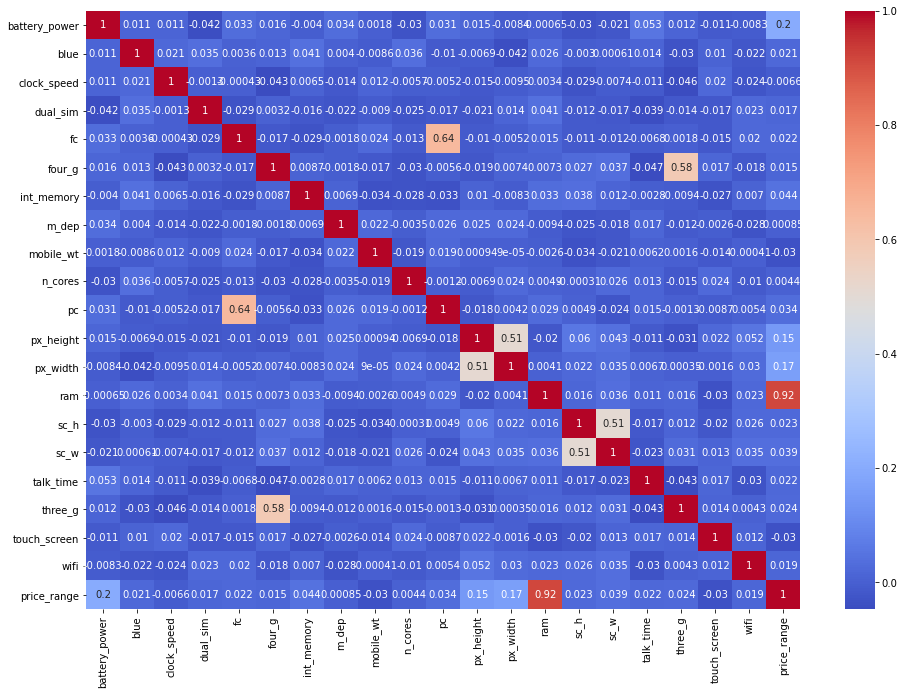

In [8]:
fig = plt.figure(figsize = (16,11))
sns.heatmap(data.corr(), annot = True, cmap = "coolwarm")

### Comprobamos valores faltantes

In [9]:
missing_values_count = data.isnull().sum()
missing_values_count

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

### Analizamos la feature a predecir (target)

Con la siguiente operacion, podemos ver de qué tipo es la variable a predecir, y observamos que tiene 4 clases o rangos

In [10]:
print(data['price_range'].describe())
print(data['price_range'].unique())

count    2000.000000
mean        1.500000
std         1.118314
min         0.000000
25%         0.750000
50%         1.500000
75%         2.250000
max         3.000000
Name: price_range, dtype: float64
[1 2 3 0]


## Clasificador SVM

Escribir algo de prosa sobre SVM

### Preparación datos de entrenamiento

Separamos la variable objetivo respecto de los datos para el entrenamiento y entrenamos el modelo

In [11]:
# importamos el escalador
scaler = MinMaxScaler()

# seleccionamos la variable target
y = np.array(data['price_range'])

# extraemos las features predictoras (todas menos el price_range)
X = data.copy()
X = data.drop(['price_range'],axis=1)
X = scaler.fit_transform(X) 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

### Modelo SVM con kernel lineal

Entrenamos el modelo utilizando un kernel lineal

In [12]:
svm_linear=SVC(
    kernel = 'linear', 
    C=1, 
    random_state=1)

svm_linear.fit(x_train,y_train)

y_test_pred_linear = svm_linear.predict(x_test)

print("---------- CLASIFICADOR SVM KERNEL LINEAL ----------")
print("train accuracy:", svm_linear.score(x_train,y_train))
print("test accuracy:", svm_linear.score(x_test,y_test))
print("ClassificationReport:\n%s"% classification_report(y_test_pred_linear, y_test))

---------- CLASIFICADOR SVM KERNEL LINEAL ----------
train accuracy: 0.959375
test accuracy: 0.93
ClassificationReport:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        93
           1       0.92      0.90      0.91        98
           2       0.91      0.88      0.89       109
           3       0.92      0.98      0.95       100

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



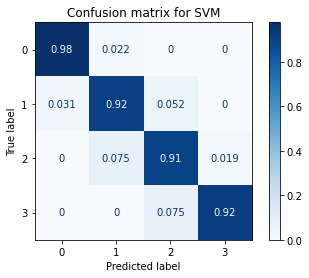

In [13]:
matrix = plot_confusion_matrix(svm_linear, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for SVM')
plt.show(matrix)
plt.show()

### Modelo SVM con kernel radial

In [14]:
svm_radial = SVC(
    kernel='rbf',
    C=1,
    random_state=1)

svm_radial.fit(x_train,y_train)

y_test_pred_radial = svm_radial.predict(x_test)

print("---------- CLASIFICADOR SVM KERNEL RADIAL ----------")
print("train accuracy:", svm_radial.score(x_train,y_train))
print("test accuracy:", svm_radial.score(x_test,y_test))
print("ClassificationReport:\n%s"% classification_report(y_test_pred_radial, y_test))

---------- CLASIFICADOR SVM KERNEL RADIAL ----------
train accuracy: 0.97125
test accuracy: 0.8375
ClassificationReport:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        95
           1       0.78      0.77      0.77        98
           2       0.81      0.74      0.77       116
           3       0.83      0.97      0.89        91

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



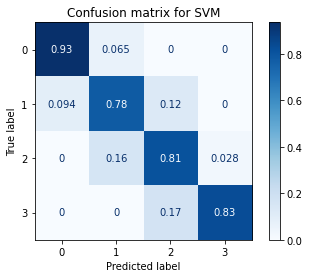

In [15]:
matrix = plot_confusion_matrix(svm_radial, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for SVM')
plt.show(matrix)
plt.show()

### Clasificadores resultantes

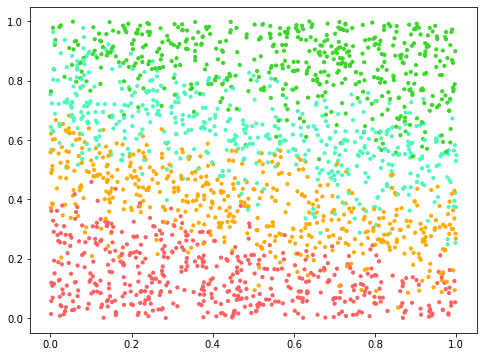

In [16]:
from matplotlib.colors import ListedColormap

# mostramos las regiones de decisión basándonos en las dos variables que más influyen sobre el 'price_range'
# para ello podemos apoyarnos en la matriz de correlación que hemos calculado antes
X = np.array(data.loc[:,['battery_power', 'ram']])
y = np.array(data['price_range'])

X = scaler.fit_transform(X)     

cm_dark = ListedColormap(['#ff6060', '#8282ff','#ffaa00','#fff244','#4df9b9','#76e8fc','#3ad628'])
cm_bright = ListedColormap(['#ffafaf', '#c6c6ff','#ffaa00','#ffe2a8','#bfffe7','#c9f7ff','#9eff93'])

fig = plt.figure(figsize = (8,6))
plt.scatter(X[:,0] ,X[:,1], c=y, cmap=cm_dark, s=10, label=y)
plt.show()

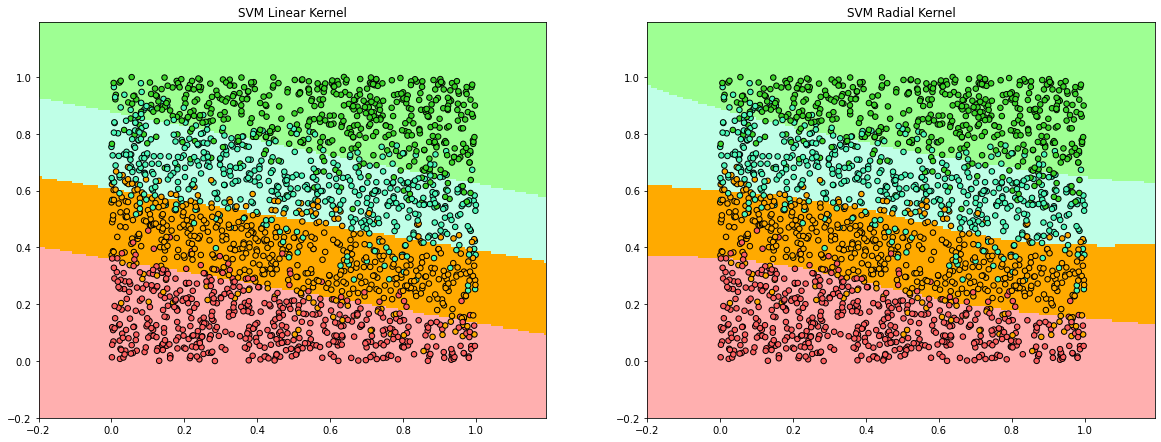

In [17]:
h = .008

# entrenamos el svm con kernel lineal
svm_linear=SVC(kernel = 'linear', C=0.1, random_state=1)
svm_linear.fit(X, y)

# entrenamos el svm con kernel radial
svm_radial = SVC(kernel = 'rbf', C=0.1, random_state=1)
svm_radial.fit(X, y)

# Pintamos las regiones de decisión asignando un color a cada una
x_min, x_max = X[:, 0].min()-.20, X[:, 0].max()+.20
y_min, y_max = X[:, 1].min()-.20, X[:, 1].max()+.20
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

linear = svm_linear.predict(np.c_[xx.ravel(), yy.ravel()])
radial = svm_radial.predict(np.c_[xx.ravel(), yy.ravel()])

# adaptamos los resultados para el plot
linear = linear.reshape(xx.shape)
radial = radial.reshape(xx.shape)

f, axs = plt.subplots(1,2,figsize=(20,16))

plt.subplot(2, 2, 1)
plt.title("SVM Linear Kernel")
plt.pcolormesh(xx, yy, linear, shading='auto',cmap=cm_bright)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_dark, edgecolor='k', s=30)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.subplot(2, 2, 2)
plt.title("SVM Radial Kernel")
plt.pcolormesh(xx, yy, radial, shading='auto',cmap=cm_bright)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_dark, edgecolor='k', s=30)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

## Clasificador Redes Neuronales

Escribir algo de prosa:
https://scikit-learn.org/stable/modules/neural_networks_supervised.html

### Preparamos los datos de entrenamiento

In [18]:
# importamos el escalador
scaler = MinMaxScaler()

# seleccionamos la variable target
y = np.array(data['price_range'])

# extraemos las features predictoras (todas menos el price_range)
X = data.copy()
X = data.drop(['price_range'],axis=1)
X = scaler.fit_transform(X)   

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

### Entrenamos la red neuronal

In [19]:
import warnings
warnings.filterwarnings("ignore")

Primero entrenamos la red utilizando una capa oculta con 3 neuronas, tal y como indican en la actividad

In [20]:
# utilizamos 'relu' como función de activación ya que hemos visto que 
# con una aproximación lineal los modelos responden bastante bien
clf_3 = MLPClassifier(
    solver='lbfgs',
    activation='relu',
    alpha=1e-4,
    hidden_layer_sizes=(3,),
    random_state=1,
    verbose=10
)

clf_3.fit(x_train, y_train)

y_test_pred = clf_3.predict(x_test)

print("train accuracy:", clf_3.score(x_train, y_train))
print("test accuracy:", clf_3.score(x_test, y_test))
print("ClassificationReport:\n%s"% classification_report(y_test_pred, y_test))

train accuracy: 0.968125
test accuracy: 0.9575
ClassificationReport:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        92
           1       0.97      0.93      0.95       100
           2       0.94      0.92      0.93       109
           3       0.93      1.00      0.97        99

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



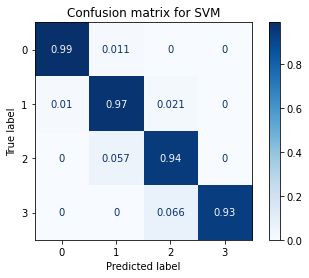

In [21]:
matrix = plot_confusion_matrix(clf_3, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for SVM')
plt.show(matrix)
plt.show()

Ahora comprobamos utilizando 4 neuronas en la capa oculta

In [22]:
clf_4 = MLPClassifier(
    solver='lbfgs',
    activation='relu',
    alpha=1e-4,
    hidden_layer_sizes=(4,),
    random_state=1,
    verbose=10
)

clf_4.fit(x_train, y_train)

y_test_pred = clf_4.predict(x_test)

print("train accuracy:", clf_4.score(x_train, y_train))
print("test accuracy:", clf_4.score(x_test, y_test))
print("ClassificationReport:\n%s"% classification_report(y_test_pred, y_test))

train accuracy: 0.99
test accuracy: 0.9675
ClassificationReport:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        92
           1       0.96      0.95      0.95        97
           2       0.96      0.95      0.96       107
           3       0.97      0.99      0.98       104

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



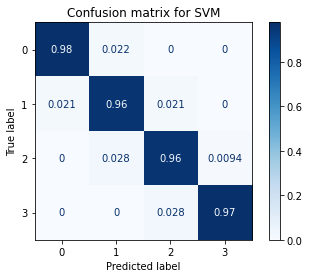

In [23]:
matrix = plot_confusion_matrix(clf_4, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for SVM')
plt.show(matrix)
plt.show()

### Buscando la mejor configuración para la red neuronal

sklearn ofrece la herramienta GridSearchCV. Podemos configurar un espacio de configuraciones con los que probar, y GridSearchCV se encargará de ir combinando las posibles soluciones, hasta finalmente obtenerla que mayor precisión ofrezca

In [24]:
mlp = MLPClassifier(max_iter=10)

parameter_space = {
    'hidden_layer_sizes': [(3,), (4,)],
    'activation': ['tanh', 'relu', 'identity', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, cv=5, verbose=3, scoring='accuracy')
clf.fit(x_train, y_train)

# Best parameter set
print('Best parameters found:\n', clf.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd, score=0.263, total=   0.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd, score=0.269, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd, score=0.191, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd, score=0.206, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam, score=0.237, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam, score=0.269, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam, score=0.253, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=lbfgs, score=0.466, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=constant, solver=lbfgs, s

[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=adam, score=0.219, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=adam, score=0.225, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=adam, score=0.250, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=lbfgs, score=0.603, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=lbfgs, s

[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam, score=0.244, total=   0.0s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam, score=0.278, total=   0.0s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam, score=0.263, total=   0.0s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=lbfgs, score=0.606, total=   0.0s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=lbfgs, score=0.750, total=

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=sgd, score=0.244, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam, score=0.256, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam, score=0.244, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam, score=0.244, total=   0.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam, score=

[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd, score=0.247, total=   0.0s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd, score=0.263, total=   0.0s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd, score=0.228, total=   0.0s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd, score=0.222, total=   0.0s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=sgd, score=0.234, total=   0.0s
[CV] 

[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam, score=0.269, total=   0.0s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam, score=0.309, total=   0.0s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=lbfgs, score=0.556, total=   0.0s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=lbfgs, score=0.597, total=   0.0s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=constant, solver=lbfgs, score=0.728, tota

[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam, score=0.266, total=   0.0s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam, score=0.250, total=   0.0s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam, score=0.350, total=   0.0s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam, score=0.256, total=   0.0s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(3,), learn

[CV]  activation=identity, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam, score=0.341, total=   0.0s
[CV] activation=identity, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam, score=0.281, total=   0.0s
[CV] activation=identity, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam, score=0.222, total=   0.0s
[CV] activation=identity, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=adam, score=0.278, total=   0.0s
[CV] activation=identity, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=constant,

[CV]  activation=identity, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=adam, score=0.219, total=   0.0s
[CV] activation=identity, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=adam, score=0.234, total=   0.0s
[CV] activation=identity, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=adam, score=0.247, total=   0.0s
[CV] activation=identity, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=lbfgs, score=0.713, total=   0.0s
[CV] activation=identity, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=0.05, hidden_layer_sizes=(4,), learning_rate=adaptiv

[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam, score=0.247, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam, score=0.253, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam, score=0.244, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=constant, solver=adam, score=0.287, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(4,), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(4,), learn

[CV]  activation=logistic, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam, score=0.256, total=   0.0s
[CV] activation=logistic, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam, score=0.247, total=   0.0s
[CV] activation=logistic, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam, score=0.316, total=   0.0s
[CV] activation=logistic, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=adam, score=0.247, total=   0.0s
[CV] activation=logistic, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.05, hidden_layer_sizes=(3,), learning_rate=adaptive,

[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    8.4s finished


In [25]:
clf = MLPClassifier(
    activation='identity',
    alpha=0.0001,
    hidden_layer_sizes=(4,),
    learning_rate='adaptive',
    solver='lbfgs'
)

clf.fit(x_train, y_train)

y_test_pred = clf.predict(x_test)

print("train accuracy:", clf.score(x_train, y_train))
print("test accuracy:", clf.score(x_test, y_test))
print("ClassificationReport:\n%s"% classification_report(y_test_pred, y_test))

train accuracy: 0.993125
test accuracy: 0.9675
ClassificationReport:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        92
           1       0.96      0.97      0.96        95
           2       0.97      0.94      0.96       109
           3       0.96      0.98      0.97       104

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



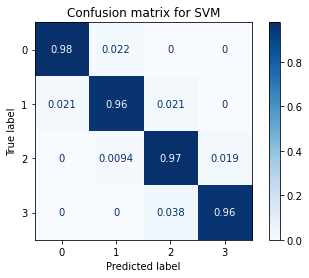

In [26]:
matrix = plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for SVM')
plt.show(matrix)
plt.show()